In [1]:
%matplotlib inline
import pandas as pd
import numpy as np


## After deriving the stochastic gradient
DF(U,V)/DU = (
            

            U[i, :] += lr * (err * V[j, :] - (lmb * U[i, :]))
            V[j, :] += lr * (err * U[i, :] - (lmb * V[j, :]))

In [2]:
data = pd.read_csv('ratings.csv')
#cast to int so IDS can be used as indices
data = data.astype(int)

In [3]:
#encoding Movie Ids as indices from 0 -> # of unique movies)))
encode, decode = {}, {}
for i, x in enumerate(data['movieId'].unique()):
    encode[x] = i
    decode[i] = x
    
data['movieId'] = data['movieId'].apply(lambda x: encode[x])



In [4]:
ratings = data.pivot(index='userId', columns='movieId', values='rating')
ratings.head()

movieId,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:

samples = data[['userId', 'movieId', 'rating']].copy()
#subtract one to map userId to proper indices 
samples['userId'] = samples['userId'] - 1
samples = samples.values
#preview the samples array. userId, movieId, rating
samples

array([[   0,    0,    4],
       [   0,    1,    4],
       [   0,    2,    4],
       ...,
       [ 609, 3121,    5],
       [ 609, 1392,    5],
       [ 609, 2873,    3]], dtype=int64)

In [6]:
#rsme calculator
def rmse(dset, preds):
    rmse = 0 
    for i, j, rating in dset:
        rmse += np.power((rating - preds[i, j]), 2)
    return np.sqrt(1/len(dset) * rmse)

#objective function to calculate
def calculate_loss(loss_err, lmb, U, V):
    return 1/2*(np.sum(np.power(loss_err, 2))+ lmb/2*(np.power(np.linalg.norm(U, ord='fro'), 2) 
                                                      + np.power(np.linalg.norm(V, ord='fro'), 2)))


In [7]:
#shuffling dataset
np.random.shuffle(samples)

In [8]:
#setting our parameters 
lr = .01
lmb = float(1)
#num of times we run gradient descent
epochs = 25
K = 1

#model to train our function
def train_model(lr, lmb, K, epochs):
    '''lr: learning rate
       lmb: regularization parameter
       K: number of latent dimensions
       epochs: #numer of times to run SGD

       returns
       losses: objective function after each epoch
       error: rmse of train/test sets'''
    
    len_users, len_movies = ratings.shape
    U = np.random.normal(scale=1./K, size=(len_users, K))
    V = np.random.normal(scale=1./K, size=(len_movies, K))

    train = samples[:90000]
    test = samples[90000:]
    error, losses = [], []
    
    for iteration in range(1, epochs+1):
        loss_err = []
        #shuffles train set before running SGD
        np.random.shuffle(train)
        for i, j, rating in train:
            pred = U[i,:] * V[j,:]
            err = (rating - pred)
            loss_err += [err]
            
            U[i, :] += lr * (err * V[j, :] - (lmb * U[i, :]))
            V[j, :] += lr * (err * U[i, :] - (lmb * V[j, :]))
        
        res = U @ V.T
        
        #calculates loss and train
        loss = calculate_loss(loss_err, lmb, U, V)
        rmse_train = rmse(train, res)
        rmse_test = rmse(test, res)
        if iteration % 10 == 0:
            print('iteration', iteration, '\nloss for train\n', loss)
        error += [(rmse_train, rmse_test)]
        losses += [loss]
    return error, losses

training_error, loss_curve = train_model(lr, lmb, K, epochs)

iteration 10 
loss for train
 120622.73803952069
iteration 20 
loss for train
 95360.74710723976


## Analysis
After about 10 iterations of gradient descent, our loss function begins to converge. 

I then looked at the training vs test RMSE, the results are as expected, the RMSE decreases in accordance with the loss and the loss of our test is slightly higher than our training dataset. 

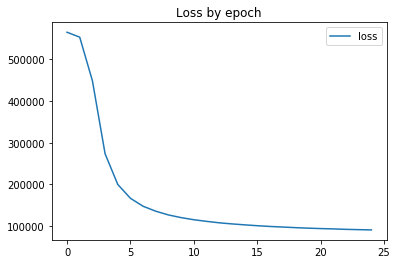

In [9]:
#plotting
pd.DataFrame(data=loss_curve, columns=['loss']).plot(title='Loss by epoch')

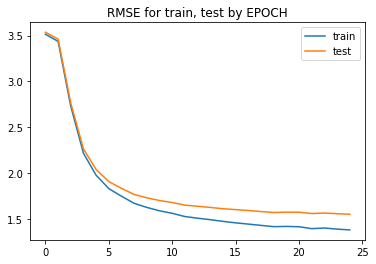

In [17]:
pd.DataFrame(data=training_error, columns=['train', 'test']).plot(title='RMSE for train, test by EPOCH')

In [11]:
ending = training_error[-1]
print('training RMSE', round(ending[0], 3), 'testing RMSE', round(ending[1], 3))

training RMSE 1.378 testing RMSE 1.55


## Analysis
As we can see, lower lambdas are our optimum in this case. The higher the regularization parameter the lower the MSE, as our regularization portion of our gradient overcomes our learning rate portion. Perhaps this would change with a subsequent higher learning rate, but in previous experimentation the learning rate was very sensitive and could cause the algorithm to not converge so I kept it constant for this test.

The highest lambdas caused gradient explosion which made it impossible to fit our model as it pushed the gradient towards higher numbers than python/numpy can handle 


Our optimal lambda appears to be somewhere between 0 & .5 as we get the lowest MSE at .1

In [18]:
#predicting for all of the lambdas 
results = {}
for reg in [10**-6, 10**-3, .1, .5, 2, 5, 10, 
           20, 50, 100, 500, 1000]:
    
    #iterating through the learning rates 
    print('\n\npredicting for', reg)
    results[reg] = train_model(lr, float(reg), K, 25)[0]
    
    



predicting for 1e-06
iteration 10 
loss for train
 55065.39290655268
iteration 20 
loss for train
 38308.11264177381


predicting for 0.001
iteration 10 
loss for train
 54488.99079229727
iteration 20 
loss for train
 38086.822576559294


predicting for 0.1
iteration 10 
loss for train
 62899.72698884802
iteration 20 
loss for train
 42332.67637422059


predicting for 0.5
iteration 10 
loss for train
 78675.32786002035
iteration 20 
loss for train
 57695.94863121851


predicting for 2
iteration 10 
loss for train
 285461.56763312896
iteration 20 
loss for train
 237401.3041185677


predicting for 5
iteration 10 
loss for train
 560433.1809153871
iteration 20 
loss for train
 559285.2654176392


predicting for 10
iteration 10 
loss for train
 560428.9634783964
iteration 20 
loss for train
 559482.609692518


predicting for 20
iteration 10 
loss for train
 560407.5261333061
iteration 20 
loss for train
 560211.0075895925


predicting for 50
iteration 10 
loss for train
 563680.89990023

c:\users\ianwright\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply
c:\users\ianwright\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
c:\users\ianwright\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in add
c:\users\ianwright\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract
c:\users\ianwright\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
c:\users\ianwright\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in power
  # Remove the CWD from sys.path while we load stuff.


iteration 10 
loss for train
 nan
iteration 20 
loss for train
 nan


predicting for 1000
iteration 10 
loss for train
 nan
iteration 20 
loss for train
 nan


In [19]:
end = {x: y[-1] for x, y in results.items()}

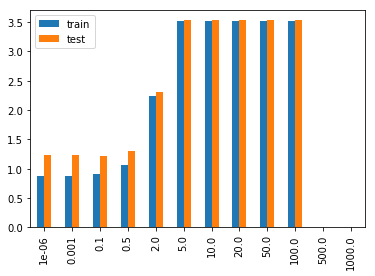

In [20]:
end_plot = pd.DataFrame.from_dict(data = end).T
end_plot.columns = ['train', 'test']
end_plot.plot(kind='bar')

In [21]:
end_plot

,train,test
0.000001,0.870102,1.237929
0.001000,0.868257,1.225508
0.100000,0.906346,1.209325
0.500000,1.055367,1.296233
2.000000,2.236296,2.311954
5.000000,3.522037,3.534881
10.000000,3.522046,3.534856
20.000000,3.522046,3.534868
50.000000,3.522046,3.534868
100.000000,3.522046,3.534868
